<h1><center>
    ECE 438 - Laboratory 6a<br/>
    Discrete Fourier Transform and Fast Fourier Transform Algorithms (Week 1)<br/>
    <small>Last updated on February 22, 2022</small>
</center></h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from helper import DTFT, hamming
import time

In [2]:
# make sure the plot is displayed in this notebook
%matplotlib inline
# specify the size of the plot
plt.rcParams['figure.figsize'] = (16, 6)

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

<h2 style="color:salmon;"><left>1. Introduction</left></h2>

This is the first week of a two week laboratory that covers the Discrete Fourier Transform (DFT) and Fast Fourier Transform (FFT) methods. The first week will introduce the DFT and associated sampling and windowing effects, while the second week will continue the discussion of the DFT and introduce the FFT.

In previous laboratories, we have used the Discrete-Time Fourier Transform (DTFT) extensively for analyzing signals and linear time-invariant systems.

\begin{align}
    \text{(DTFT)}\quad X(e^{j\omega})&=\sum_{n=-\infty}^{\infty}x[n]e^{-j\omega n}\tag{1}\\
    \text{(inverse DTFT)}\quad x[n]&=\frac{1}{2\pi}\int_{-\pi}^{\pi}X(e^{j\omega})e^{j\omega n}d\omega\tag{2}
\end{align}

While the DTFT is very useful analytically, it usually cannot be exactly evaluated on a computer because equation (1) requires an infinite sum and equation (2) requires the evaluation of an integral.

The discrete Fourier transform (DFT) is a sampled version of the DTFT, hence it is better suited for numerical evaluation on computers.

\begin{align}
    \text{(DFT)}\quad X_N[k]&=\sum_{n=0}^{N-1}x[n]e^{-j2\pi kn/N}\tag{3}\\
    \text{(inverse DFT)}\quad x[n]&=\frac{1}{N}\sum_{k=0}^{N-1}X_N[k]e^{j2\pi kn/N}\tag{4}
\end{align}

Here $X_N[k]$ is an $N$ point DFT of $x[n]$. Note that $X_N[k]$ is a function of a discrete integer $k$, where $k$ ranges from $0$ to $N − 1$.

In the following sections, we will study the derivation of the DFT from the DTFT, and several DFT implementations. The fastest and most important implementation is known as the fast Fourier transform (FFT). The FFT algorithm is one of the cornerstones of signal processing.

<h2 style="color:salmon;"><left>2. Deriving the DFT from DTFT</left></h2>

<h3 style="color:salmon;"><left>2.1 Truncating the Time-domain Signal</left></h3>

The DTFT usually cannot be computed exactly because the sum in equation (1) is infinite. However, the DTFT may be approximately computed by truncating the sum to a finite window. Let $w[n]$ be a rectangular window of length $N$:

\begin{equation}
    w[n]=\begin{cases}
        1&0\leq n\leq N-1\\
        0&\text{else}
    \end{cases}\tag{5}
\end{equation}

Then we may define a truncated signal to be

\begin{equation}
    x_{\text{tr}}[n]=w[n]x[n]\tag{6}
\end{equation}

The DTFT of $x_{\text{tr}}[n]$ is given by:

\begin{align}
    X_{\text{tr}}(e^{j\omega})&=\sum_{n=-\infty}^{\infty}x_{\text{tr}}[n]e^{-j\omega n}\tag{7}\\
    &=\sum_{n=0}^{N-1}x[n]e^{-j\omega n}\tag{8}
\end{align}

We would like to compute $X(e^{j\omega})$, but as with filter design, the truncation window distorts the desired frequency characteristics; $X(e^{j\omega})$ and $X_{\text{tr}}(e^{j\omega})$ are generally not equal. To understand the relation between these two DTFT’s, we need to convolve in the frequency domain (as we did in designing filters with the truncation technique):

\begin{equation}
    X_{\text{tr}}(e^{j\omega})=\frac{1}{2\pi}\int_{-\pi}^{\pi}X(e^{j\sigma})W(e^{j(\omega-\sigma)})d\sigma\tag{9}
\end{equation}

where $W(e^{j\omega})$ is the DTFT of $w[n]$. Equation (9) is the periodic convolution of $X(e^{j\omega})$ and $W(e^{j\omega})$. Hence the true DTFT, $X(e^{j\omega})$, is smoothed via convolution with $W(e^{j\omega})$ to produce the truncated DTFT, $X_{\text{tr}}(e^{j\omega})$.

We can calculate $W(e^{j\omega})$:

\begin{align}
    W(e^{j\omega})&=\sum_{n=-\infty}^\infty w[n]e^{-j\omega n}\\
    &=\sum_{n=0}^{N-1}e^{-j\omega n}\\
    &=\begin{cases}\frac{1-e^{-j\omega N}}{1-e^{-j\omega}}&\quad\text{for }\omega\neq0,\pm2\pi\\N&\quad\text{for }\omega=0,\pm2\pi\end{cases}\tag{10}
\end{align}

For $\omega\neq0,\pm2\pi,\dots,$ we have:

\begin{align}
    W(e^{j\omega})&=\frac{e^{-j\omega N/2}}{e^{-j\omega/2}}\frac{e^{j\omega N/2}-e^{-j\omega N/2}}{e^{j\omega/2}-e^{-j\omega/2}}\\
    &=e^{-j\omega(N-1)/2}\frac{\sin(\omega N/2)}{\sin(\omega/2)}\tag{11}
\end{align}

Notice that the magnitude of this function is similar to $\text{sinc}(\omega N/2)$ except that it is periodic in $\omega$ with period $2\pi$.

<h3 style="color:salmon;"><left>2.2 Frequency Sampling</left></h3>

Equation (8) contains a summation over a finite number of terms. However, we can only
evaluate (8) for a finite set of frequencies, $\omega$. We must sample in the frequency domain to compute the DTFT on a computer. We can pick any set of frequency points at which to evaluate (8), but it is particularly useful to uniformly sample $\omega$ at $N$ points, in the range $[0, 2\pi)$. If we substitute

\begin{align}
    \omega=2\pi k/N\tag{12}
\end{align}

for $k=0,1,\dots,(N-1)$ in (8), we find that

\begin{align}
    X_{\text{tr}}(e^{j\omega})\big\rvert_{\omega=\frac{2\pi k}{N}}&=\sum_{n=0}^{N-1}x[n]e^{-j\omega n}\bigg\rvert_{\omega=\frac{2\pi k}{N}}\\
    &=\sum_{n=0}^{N-1}x[n]e^{-j2\pi kn/N}\\
    &=X_N[k].
\end{align}

In short, the DFT values result from sampling the DTFT of the truncated signal.

\begin{align}
    X_N[k]=X_{\text{tr}}(e^{j2\pi k/N})\tag{13}
\end{align}

<h3 style="color:red;"><left>Exercise 2: Windowing Effects</left></h3>

We will next investigate the effect of windowing when computing the DFT of the signal $x(n)=\cos\left(\frac{\pi}{4}n\right)$ truncated with a window of size $N=20$.

<figure>
    <img src="imgs/figure1.png" style="width:60%">
    <em><center>Figure 1: The plot of a Hamming window (left) and its DTFT (right).</center></em>
</figure>

**1. Plot the magnitude of $W(e^{j\omega})$, using equations (10) and (11).**

In [ ]:
# insert your code here


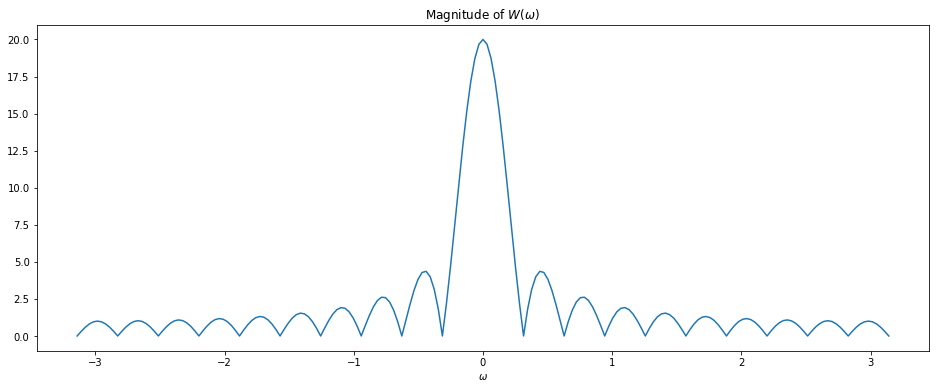

In [3]:
N = 20
w = np.arange(-np.pi, np.pi+np.pi/100, np.pi/100)
W = np.zeros(w.shape).astype(complex)
for i in range(len(W)):
    if i != 0:
        W[i] = (1 - np.exp(-1j*w[i]*N)) / (1 - np.exp(-1j*w[i]))
plt.plot(w, np.abs(W))
plt.title(r"Magnitude of $W(\omega)$")
plt.xlabel(r"$\omega$")
plt.show()

**2. Plot the phase of $W(e^{j\omega})$, using equations (10) and (11).**

In [4]:
# insert your code here


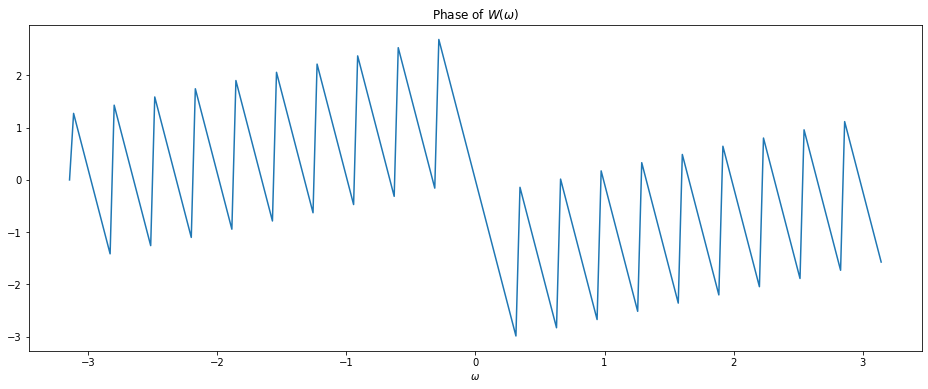

In [5]:
plt.plot(w, np.angle(W))
plt.title(r"Phase of $W(\omega)$")
plt.xlabel(r"$\omega$")
plt.show()

**3. Determine an analytical expression for $X(e^{j\omega})$ (the DTFT of the non-truncated signal).**

insert your answer here

$X(\omega)=\pi\text{rep}_{2\pi}\left(\delta\left(\omega-\frac{\pi}{4}\right) + \delta\left(\omega+\frac{\pi}{4}\right)\right)$

**4. Truncate the signal $x[n]$ using a window of size $N = 20$ and then use ```DTFT``` to compute $X_{\text{tr}}(e^{j\omega})$. Then plot the magnitude of $X_{\text{tr}}(e^{j\omega})$. Make sure that the plot contains a least 512 points.**

**Hint:** Use the command ```X, w = DTFT(x, 512)```.

In [6]:
# insert you code here


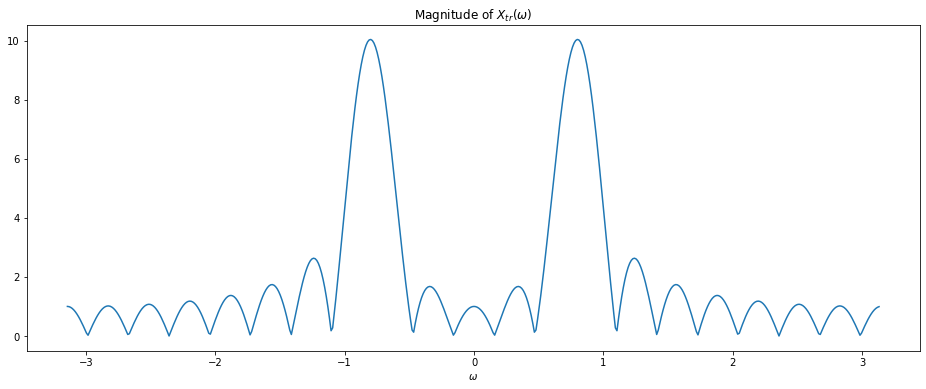

In [7]:
n = np.arange(N)
x = np.cos(np.pi/4*n)
X_tr, w_tr = DTFT(x, 512)
plt.plot(w_tr, np.abs(X_tr))
plt.title(r"Magnitude of $X_{tr}(\omega)$")
plt.xlabel(r"$\omega$")
plt.show()

**5. Describe the difference between $|X_{\text{tr}}(e^{j\omega})$ and $|X(e^{j\omega})|$. What is the reason for this difference?**

insert your answer here

$|X_\text{tr}(\omega)|$ is two impulses located at $\omega=-\frac{\pi}{4}$ and $\omega=\frac{\pi}{4}$, while $|X(\omega)|$ is two sinc functions located at these two frequencies.<br/><br/>
The reason is that the rect function in time domain is sinc in frequency domain.

**6. What would you expect your plots to look like if you had used a Hamming window in place of the truncation (rectangular) window? (See Fig. 1 for a plot of a Hamming window of length 20 and its DTFT.) Submit the plot of the magnitude of the DTFT of the signal $x[n]$ windowed using a Hamming window. (Hint: The Python command for a Hamming window is `hamming(N)`.)**

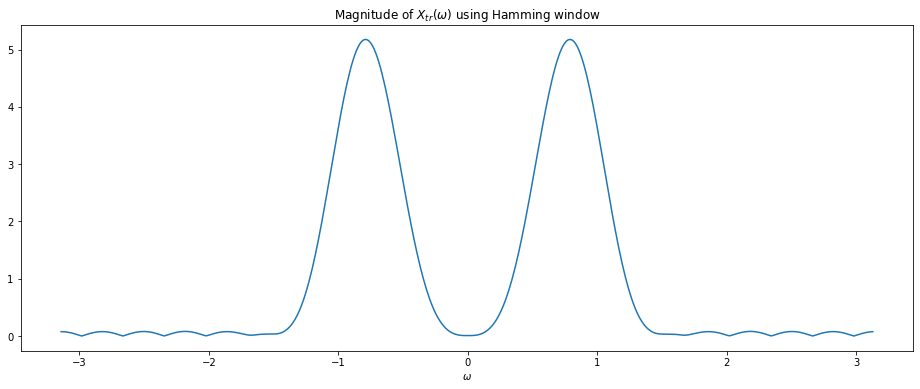

In [8]:
hamming_window = hamming(N)
x = x * hamming_window
X_ham, w_ham = DTFT(x, 512)
plt.plot(w_tr, np.abs(X_ham))
plt.title(r"Magnitude of $X_{tr}(\omega)$ using Hamming window")
plt.xlabel(r"$\omega$")
plt.show()

**7. Comment on the effects of using a different window for $w[n]$.**

insert your answer here

Now the plot looks less distorted. The plot looks the DTFT of the Hamming window located at $\omega=-\frac{\pi}{4}$ and $\omega=\frac{\pi}{4}$.

<h2 style="color:salmon;"><left>3. The Discrete Fourier Transform</left></h2>

<h3 style="color:red;"><left>Exercise 3.1: Computing the DFT</left></h3>

We will now develop our own DFT functions to help our understanding of how the DFT comes from the DTFT.

**1. Write your own Python function to implement the DFT of equation (3). Your routine should implement the DFT exactly as specified by (3) using *for-loops* for $n$ and $k$, and computing the exponentials as they appear.**

**Hint:** initialize `X` as a vector of complex values by using ```.astype(complex)```.

In [9]:
def DFTsum(x):
    """
    Parameters:
    ---
    x: the input signal, an N point vector contining the values x[0], ..., x[N - 1]
    
    Returns:
    ---
    X: the DFT of x
    """
    X = None
    return X

In [10]:
def DFTsum(x):
    """
    Parameters:
    ---
    x: the input signal, an N point vector contining the values x[0], ..., x[N - 1]
    
    Returns:
    ---
    X: the DFT of x
    """
    N = len(x)
    X = np.zeros(N).astype(complex)
    for k in range(N):
        for n in range(N):
            X[k] += x[n] * np.exp(-1j * 2 * np.pi * k * n / N)
    return X

**2. Test your routine ```DFTsum``` by computing $X_N(k)$ for each of the following cases:**

* $x(n)=\delta(n)\quad\text{for }N=10$
* $x(n)=1\quad\text{for }N=10$
* $x(n)=e^{j2\pi n/10}\quad\text{for }N=10$
* $x(n)=\cos(2\pi n/10)\quad\text{for }N=10$

**and plot the magnitude of each of the DFT’s.**

In [11]:
# first case


In [12]:
# second case


In [13]:
# third case


In [14]:
# fourth case


In [15]:
N = 10
n = np.arange(N)

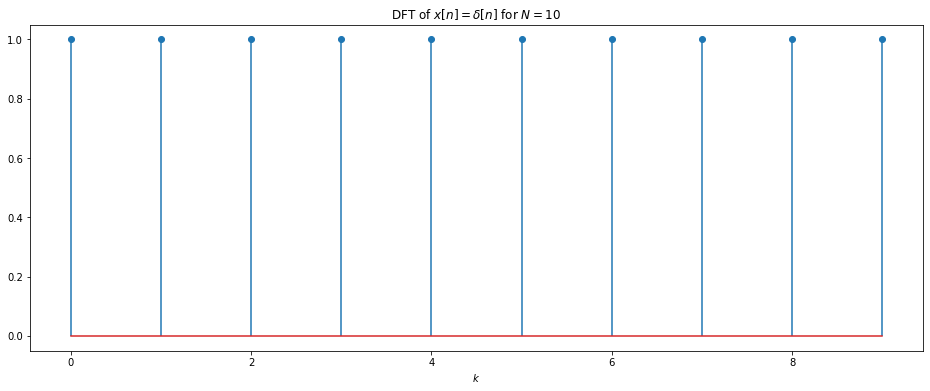

In [16]:
# first signal
x1 = (n == 0).astype(int)
X1 =DFTsum(x1)
plt.stem(n, abs(X1))
plt.title(r"DFT of $x[n]=\delta[n]$ for $N=10$")
plt.xlabel(r"$k$")
plt.show()

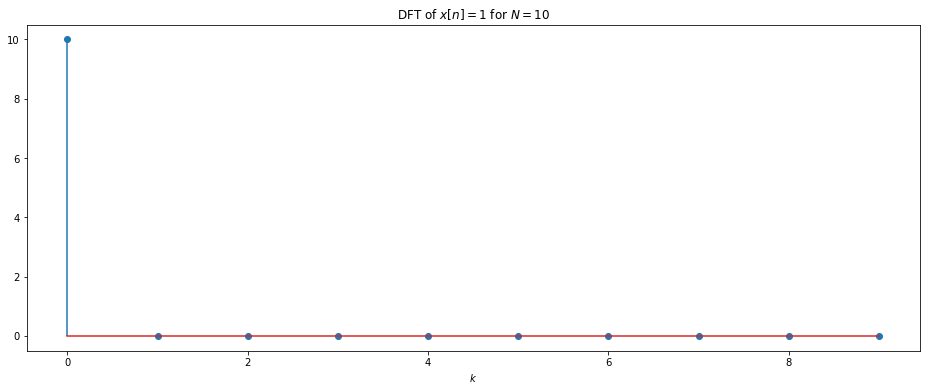

In [17]:
# second signal
x2 = (n == n).astype(int)
X2 = DFTsum(x2)
plt.stem(n, abs(X2))
plt.title(r"DFT of $x[n]=1$ for $N=10$")
plt.xlabel(r"$k$")
plt.show()

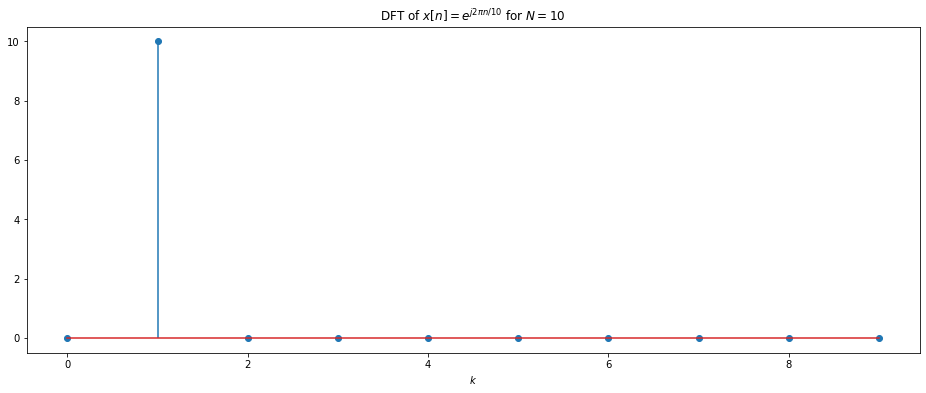

In [18]:
# third signal
x3 = np.exp(1j*2*np.pi*n/10)
X3 = DFTsum(x3)
plt.stem(n, abs(X3))
plt.title(r"DFT of $x[n]=e^{j2\pi n/10}$ for $N=10$")
plt.xlabel(r"$k$")
plt.show()

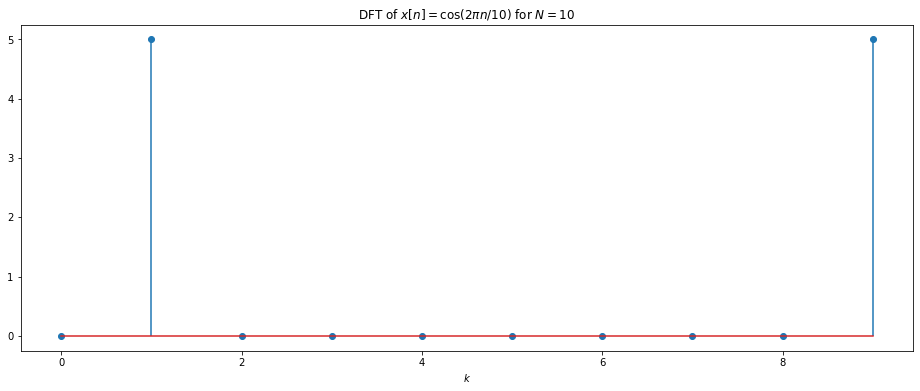

In [19]:
# fourth signal
x4 = np.cos(2*np.pi*n/10)
X4 = DFTsum(x4)
plt.stem(n, abs(X4))
plt.title(r"DFT of $x[n]=\cos(2\pi n/10)$ for $N=10$")
plt.xlabel(r"$k$")
plt.show()

**3. Derive simple closed-form analytical expressions for the DFT (not the DTFT!) of each signal.**

insert your answer here

Analytical expression for the first signal: $X_{10}(k)=1$

Analytical expression for the second signal: $X_{10}(k)=10\delta(k)$

Analytical expression for the third signal: $X_{10}(k)=10\delta(k-1)$

Analytical expression for the fourth signal: $X_{10}(k)=5\delta(k-1)+5\delta(k-9)$

<h3 style="color:red;"><left>Exercise 3.2: Computing the Inverse DFT</left></h3>

**1. Write a Python function for computing the inverse DFT of (4).**

In [20]:
def IDFTsum(X):
    '''
    Parameters:
    ---
    X: the N point vector containing the DFT
    
    Returns:
    ---
    x: the corresponding time-domain signal
    '''
    x = None
    return x

In [21]:
def IDFTsum(X):
    N = len(X)
    x = np.zeros(N).astype(complex)
    for n in range(N):
        for k in range(N):
            x[n] += X[k] * np.exp(1j*2*np.pi*k*n/N)
    return x / N

**2. Use ```IDFTsum``` to invert each of the DFT’s computed in the previous problem. Plot the magnitudes of the inverted DFT’s, and verify that those time-domain signals match the original ones. Use ```np.real()``` to eliminate any imaginary parts which roundoff error may produce.**

In [22]:
# insert your code here


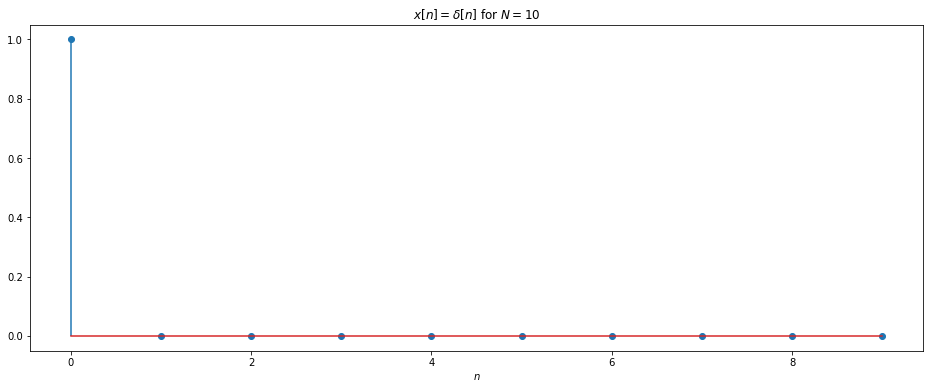

In [27]:
x1 = IDFTsum(X1)
plt.stem(n, np.real(x1))
plt.title(r"$x[n]=\delta[n]$ for $N=10$")
plt.xlabel(r"$n$")
plt.show()

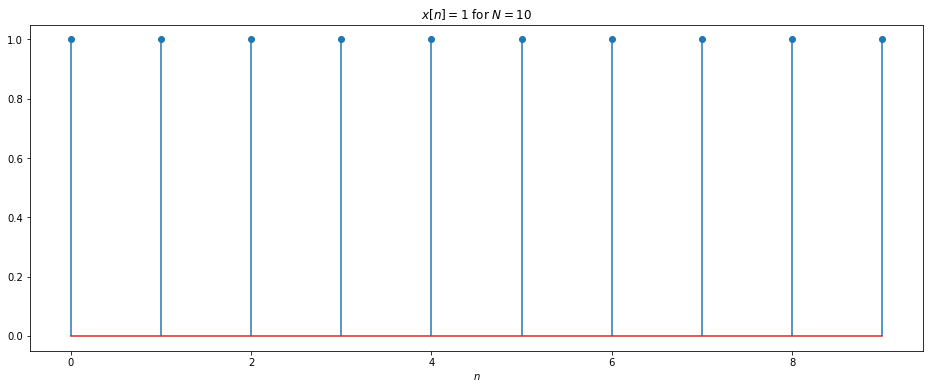

In [28]:
x2 = IDFTsum(X2)
plt.stem(n, np.real(x2))
plt.title(r"$x[n]=1$ for $N=10$")
plt.xlabel(r"$n$")
plt.show()

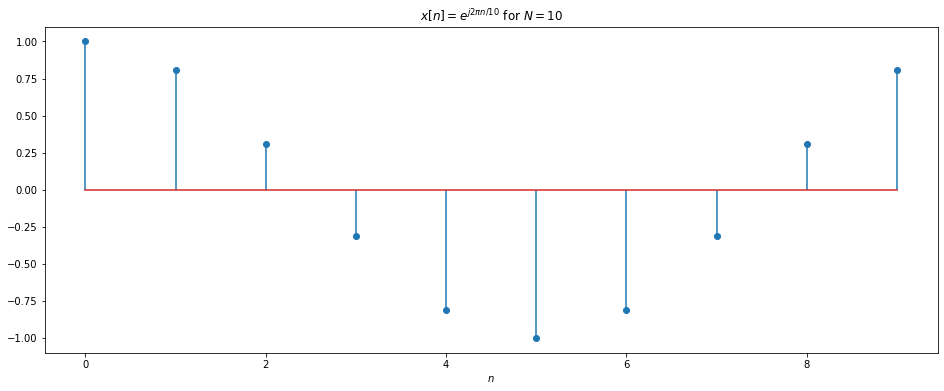

In [29]:
x3 =IDFTsum(X3)
plt.stem(n, np.real(x3))
plt.title(r"$x[n]=e^{j2\pi n/10}$ for $N=10$")
plt.xlabel(r"$n$")
plt.show()

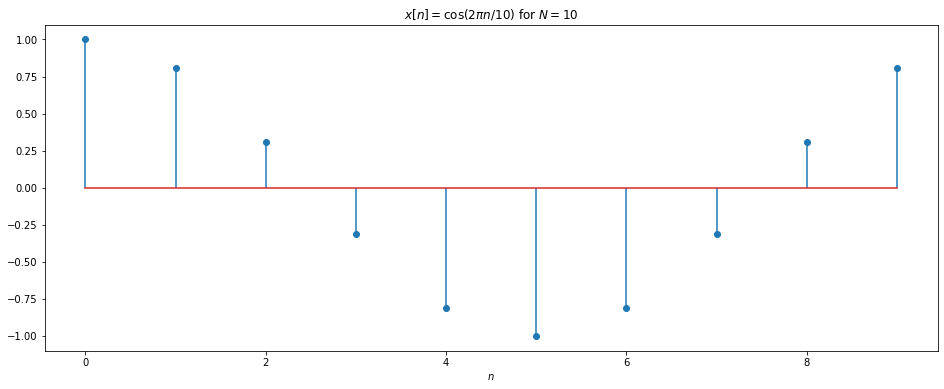

In [30]:
x4 = IDFTsum(X4)
plt.stem(n, np.real(x4))
plt.title(r"$x[n]=\cos(2\pi n/10)$ for $N=10$")
plt.xlabel(r"$n$")
plt.show()

<h3 style="color:red;"><left>Exercise 3.3: Matrix Representation of the DFT</left></h3>

The DFT of (3) can be implemented as a matrix-vector product. To see this, consider the equation

\begin{equation}
    X=Ax\tag{14}
\end{equation}

where $A$ is an $N \times N$ matrix, and both $X$ and $x$ are $N \times 1$ column vectors. This matrix product is equivalent to the summation

\begin{equation}
    X_k=\sum_{n=0}^{N-1}A_{kn}x_n\tag{15}
\end{equation}

where $A_{kn}$ is the matrix element in the $k$th row and $n$th column of $A$. By comparing equations (3) and (15) we see that for the DFT,

\begin{equation}
    A_{kn}=e^{-j2\pi kn/N}\tag{16}
\end{equation}

**1. Write a Python function for computing the $N\times N$ DFT matrix $A$ in equation (16).**

In [ ]:
def DFTmatrix(N):
    """
    Parameters:
    ---
    N: N point DFT
    
    Returns:
    ---
    A: an N x N DFT matrix
    """
    A = None
    return A

In [31]:
def DFTmatrix(N):
    """
    Parameters:
    ---
    N: N point DFT
    
    Returns:
    ---
    A: an N x N DFT matrix
    """
    A = np.zeros((N, N)).astype(complex)
    for k in range(A.shape[0]):
        for n in range(A.shape[1]):
            A[k, n] = np.exp(-1j*2*np.pi*k*n/N)
    return A

**2. Print out the matrix $A$ for $N=5$.**

In [ ]:
# insert your code here


In [32]:
A5 = DFTmatrix(5)
print(A5)

[[ 1.        +0.j          1.        +0.j          1.        +0.j
   1.        +0.j          1.        +0.j        ]
 [ 1.        +0.j          0.30901699-0.95105652j -0.80901699-0.58778525j
  -0.80901699+0.58778525j  0.30901699+0.95105652j]
 [ 1.        +0.j         -0.80901699-0.58778525j  0.30901699+0.95105652j
   0.30901699-0.95105652j -0.80901699+0.58778525j]
 [ 1.        +0.j         -0.80901699+0.58778525j  0.30901699-0.95105652j
   0.30901699+0.95105652j -0.80901699-0.58778525j]
 [ 1.        +0.j          0.30901699+0.95105652j -0.80901699+0.58778525j
  -0.80901699-0.58778525j  0.30901699-0.95105652j]]


**3. Use the matrix $A$ to compute the DFT of the following signals.**

* $x(n)=\delta(n)\quad\text{for }N=10$
* $x(n)=1\quad\text{for }N=10$
* $x(n)=e^{j2\pi n/N}\quad\text{for }N=10$

In [ ]:
# insert your code here


In [33]:
N = 10
n = np.arange(N)
k = np.arange(N)
# first signal
x1 = (n == 0).astype(int)
x1 = x1.reshape(-1, 1)
# second signal
x2 = (n == n).astype(int)
x2 = x2.reshape(-1, 1)
# third signal
x3 = np.exp(1j*2*np.pi*n/10)
x3 = x3.reshape(-1, 1)
# fourth signal
x4 = np.cos(2*np.pi*n/10)
x4 = x4.reshape(-1, 1)

A = DFTmatrix(N)
X1 = A.dot(x1)
X2 = A.dot(x2)
X3 = A.dot(x3)

**4. Plot the magnitude plots of these 3 DFTs.**

In [ ]:
# the DFT of the first signal


In [ ]:
# the DFT of the second signal


In [ ]:
# the DFT of the third signal


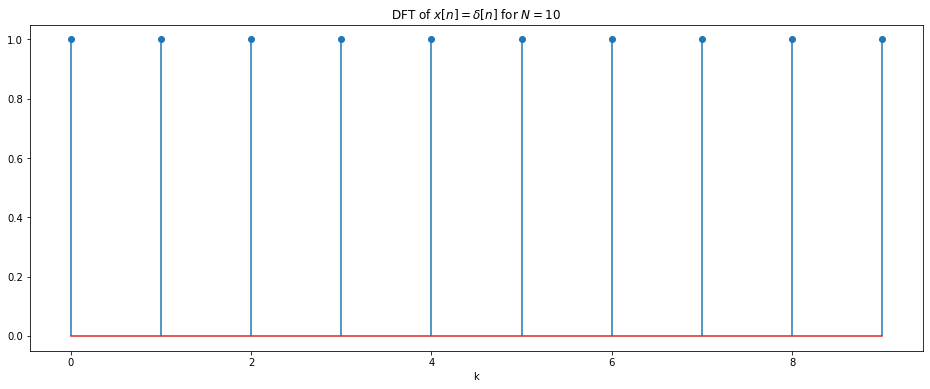

In [34]:
plt.stem(k, np.abs(X1))
plt.title(r"DFT of $x[n]=\delta[n]$ for $N=10$")
plt.xlabel("k")
plt.show()

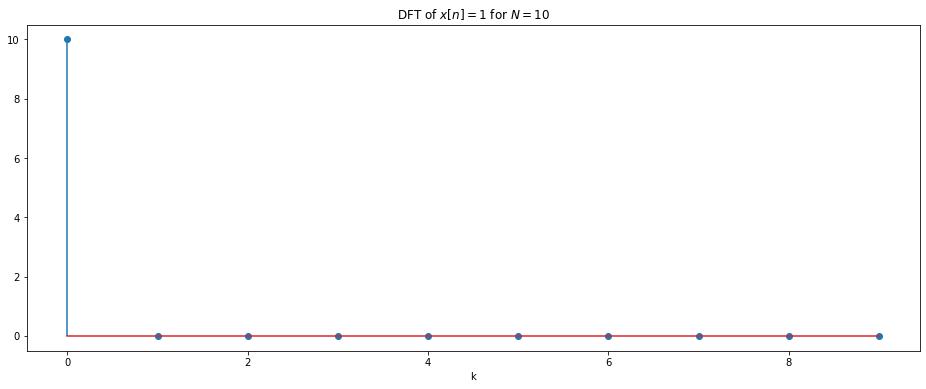

In [35]:
plt.stem(k, np.abs(X2))
plt.title(r"DFT of $x[n]=1$ for $N=10$")
plt.xlabel("k")
plt.show()

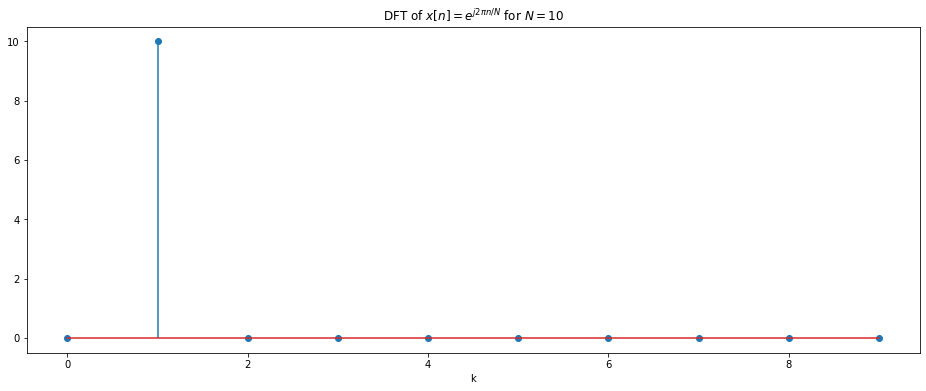

In [36]:
plt.stem(k, np.abs(X3))
plt.title(r"DFT of $x[n]=e^{j2\pi n/N}$ for $N=10$")
plt.xlabel("k")
plt.show()

**5. How many multiplies are required to compute an $N$ point DFT using the matrix method (Consider a multiply as the multiplication of either complex or real numbers.)**

insert your answer here

$N^2$

<h3 style="color:red;"><left>Exercise 3.4: Matrix Representation of the Inverse DFT</left></h3>

As with the DFT, the inverse DFT may also be represented as a matrix-vector product

\begin{equation}
    x=BX
\end{equation}

**1. Write an analytical expression for the elements of the inverse DFT matrix ```B```, using
the form of equation (16).**

insert your answer here

$B_{kn}=\frac{1}{N}e^{j2\pi kn/N}$

**2. Write a Python function for computing the $N\times N$ inverse DFT matrix $B$.**

In [ ]:
def IDFTmatrix(N):
    """
    Parameters:
    ---
    N: N-point IDFT
    
    Returns:
    ---
    B: the N x N inverse DFT matrix
    """
    B = None
    return B

In [ ]:
def IDFTmatrix(N):
    A = np.zeros((N, N)).astype(complex)
    for k in range(A.shape[0]):
        for n in range(A.shape[1]):
            A[k, n] = np.exp(1j*2*np.pi*k*n/N)
    return A / N

**3. Print out the matrix $B$ for $N=5$.**

In [ ]:
# insert your code here


In [ ]:
B = IDFTmatrix(5)
print(B)

**4. Compute the matrices $A$ for $N = 5$. Then compute and print out the elements of $C=BA$.**

In [ ]:
# insert your code here


In [ ]:
A = DFTmatrix(5)
C = B.dot(A)
C = C.round(2)
print(C)

**5. What form does $C$ have? Why does it have this form?**

insert your answer here

It is an identity matrix.

<h3 style="color:red;"><left>Exercise 3.5: Computation Time Comparison</left></h3>

Although the operations performed by `DFTsum(x)` are mathematically identical to a matrix product, the computation times for these two DFT's in Python are quite different. (This is despite the fact that the computational complexity of two procedures is of the same order!) This exercise will underscore why you should try to avoid using *for* loops in Python, and wherever possible, try formulate your computations using matrix/vector products.

To see this, do the following:

**1. Compute the signal $x(n)=\cos(2\pi n/10)$ for $N=512$.**

In [ ]:
# insert your code here


In [ ]:
N = 512
n = np.arange(N)
x = np.cos(2*np.pi*n/10)

**2. Compute the matrix $A$ for $N=512$.**

In [ ]:
# insert your code here


In [ ]:
N = 512
A = DFTmatrix(N)

**3. Compare the computation time of `DFTsum(x)` with a matrix implementation ```X = A.dot(x)``` by using the *time* function from *time* library before and after  the program execution (See the example below). Do not include the computation of $A$ in your timing calculations.**

**Report the time required for each of the two implementations.**

```python
t1 = time.time()
# program execution
t2 = time.time()
print(f"time taken: {t2 - t1:.4f}")
```

In [ ]:
# insert your code here


In [ ]:
# DFTsum method
start = time.time()
X = DFTsum(x)
end = time.time()
print("DFTsum method: {:.5f} seconds".format(end - start))

# Matrix method
start = time.time()
X = A.dot(x.reshape(-1, 1))
end = time.time()
print("Matrix method: {:.5f} seconds".format(end - start))

**4. Which method is faster? Which method requires less storage?**

insert your answer here

The matrix method is much faster, but it requires more space to store the $N\times N$ matrix.